In [1]:
import colorgram
import numpy as np
import cv2
from colorthief import ColorThief
from matplotlib import pyplot as plt

In [165]:
def rgb2list(rgb_obj):
    return (rgb_obj.r, rgb_obj.g, rgb_obj.b)

fname = 'test-images/roof.jpg'

In [2]:
color_num = 10

# Gonna use colorthief, even if it is slow af
# Get palette from ColorThief
color_thief = ColorThief(fname)
thief_palette = color_thief.get_palette(quality=5, color_count=color_num)
thief_palette.append(color_thief.get_color(quality=5))

# Get palette from colorgram
gram_palette = [rgb2list(item.rgb) for item in colorgram.extract(fname, color_num)]

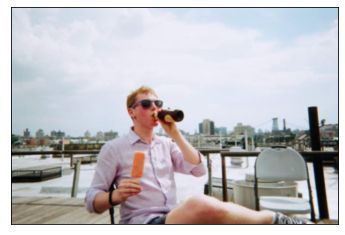

In [166]:
img = cv2.imread(fname, 1)
img = img[:,:,::-1]
plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([]) 
plt.show()

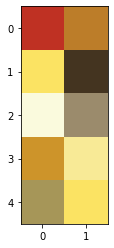

In [45]:
# plotting the palette from colorthief
pal = np.asarray(thief_palette)
pal.shape = [int(color_num/2), 2, 3]

plt.imshow(pal)

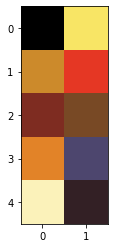

In [46]:
# plotting the palette from colorgram
pal = np.asarray(gram_palette)
pal.shape = [int(color_num/2), 2, 3]

plt.imshow(pal)

In [9]:
def read_transparent_png(filename):
    image_4channel = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    alpha_channel = image_4channel[:,:,3]
    rgb_channels = image_4channel[:,:,:3]

    # White Background Image
    white_background_image = np.ones_like(rgb_channels, dtype=np.uint8) * 255

    # Alpha factor
    alpha_factor = alpha_channel[:,:,np.newaxis].astype(np.float32) / 255.0
    alpha_factor = np.concatenate((alpha_factor,alpha_factor,alpha_factor), axis=2)

    # Transparent Image Rendered on White Background
    base = rgb_channels.astype(np.float32) * alpha_factor
    white = white_background_image.astype(np.float32) * (1 - alpha_factor)
    final_image = base + white
    return final_image.astype(np.uint8)

img = read_transparent_png(fname)

In [167]:
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

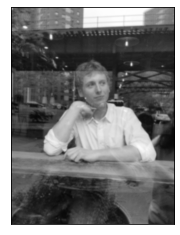

In [143]:
plt.imshow(img_lab[:,:,0], interpolation = 'bicubic', cmap='gray')
plt.xticks([]), plt.yticks([]) 
plt.show()

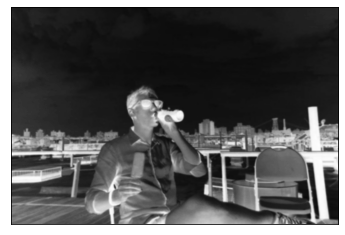

In [172]:
plt.imshow(1 - img_lab[:,:,0]/255, interpolation = 'bicubic', cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [171]:
stat_dist = 1 - img_lab[:, :, 0]/255
image_dims = stat_dist.shape
print(image_dims)

(720, 1085)


In [113]:
def metropolis_hastings(stat_dist, ini_point, it_num, bandwidth):
    # Initialize everything
    it_list = [None]*(it_num + 1)
    img_dims = stat_dist.shape
    xlim, ylim = image_dims
    it_list[0] = ini_point
    
    # Function which generates a proposal until we're always within
    # the boundary of the image
    def gen_new_pixel(loc, scale):
        return_count = 1
        
        while return_count:
            new_pixel = tuple(int(round(i)) for i in np.random.normal(loc, scale))
            #print(new_pixel)
            if (0 <= new_pixel[0] < xlim) & (0 <= new_pixel[1] < ylim):
                return_count = 0
                
        return new_pixel        
    
    # Generate samples from stat_dist in terms of pixel locations
    for i in range(it_num):
        # Generate new proposal
        new_pixel = gen_new_pixel(it_list[i], bandwidth)
        
        # Calculate acceptance probability
        accept_prob = min(1, stat_dist[new_pixel]/stat_dist[it_list[i]])
        
        # Decide whether to accept or reject the new pixel location
        if (np.random.random() < accept_prob):
            it_list[i+1] = new_pixel
        else:
            it_list[i+1] = it_list[i]
    
    return it_list


In [179]:
smoke_test = 0
if smoke_test:
    it_num = 50
else:
    it_num = 100000

it_list = metropolis_hastings(stat_dist, (550, 550), it_num, 30)

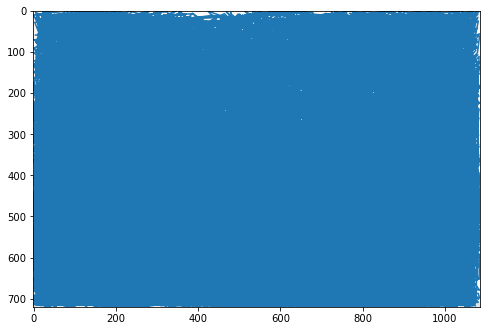

In [173]:
x, y = zip(*it_list)

plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
plt.imshow(img[:,:,::-1], interpolation = 'bicubic', alpha=0.2)
plt.plot(y, x)

plt.show()

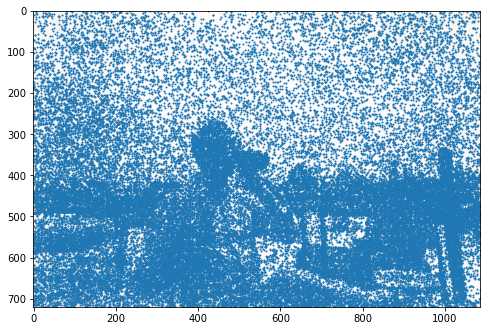

In [128]:
# note these are given in terms of (y, x), with everything 
# reversed when it comes to plotting...I think....? okay, need to fix this at some point...
image_dims

(450, 600)

In [180]:
new_img = 255*np.ones((image_dims[1], image_dims[0], 3), np.uint8)

for i in range(len(it_list) - 1):
    img_color = tuple(img[it_list[i][0], it_list[i][1], :])
    img_color = tuple([int(x) for x in img_color])
    new_img = cv2.circle(new_img, it_list[i], radius=2, color=img_color, thickness=-1)
    new_img = cv2.line(new_img, it_list[i], it_list[i+1], img_color, 1)

True

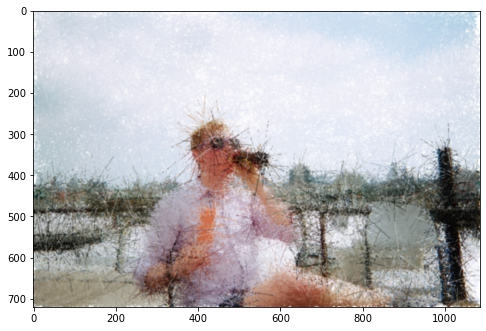

In [181]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect('equal')
img2plt = np.swapaxes(new_img[:, :, :], 0, 1)
plt.imshow(img2plt, interpolation = 'bicubic')

cv2.imwrite('test-images/roof_post2.jpg', img2plt[:,:,::-1]) 

In [ ]:
# so, ignoring the weird dimension flipping going on, this works rather well
# for pretty blocky images - I should probably try this out on a few
# more complicated images, and then see what it looks like. On these images
# I may want to try out the gradient blending too....

# other things to figure out: good choosing of the point and line widths